# 11장 - 불응과 도구변수
* 여러 사례에서 고객은 추가 서비스를 선택을 하기 때문에 서비스가 미치는 영향을 추론하기 어렵다.
* 회사가 서비스나 제품의 제공 여부를 무작위로 결정하더라도 고객이 이를 받아들이도록 강요할 수 없기 때문에 불응(non-compliance) 문제가 발생한다. 이는 처치를 배정받은 모든 사람이 처치를 받지 않는 상태를 의미한다.

In [2]:
%pip install toolz


[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from toolz.curried import *

import pandas as pd
import numpy as np
from scipy.special import expit

import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib


from cycler import cycler

color=['0.0', '0.4', '0.8']
default_cycler = (cycler(color=color))
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)


## 11.1 불응
* 처치 배정과 처치 적용 여부에 따라 4개의 그룹으로 구분할 수 있다.
    * 순응자 complier : 자신에게 배정된 처치를 받는 사람
    * 항시 참여자 always-taker : 배정과 관계없이 항상 처치를 받는 사람
    * 항시 불참자 never-taker : 배정과 관계없이 처치를 한 번도 받지 않는 사람
    * 반항자 defier : 배정된 처치와 반대되는 처치를 받는 사람
* DAG 형태로 불응을 설명하면 아래와 같다.
    * Z는 처치 배정 (무작위)
    * T는 처치
    * Y는 결과
    * U는 처치 선택과 결과에 교란을 주는 숨겨진 요인
* Z 가 1) 교란 없이 처치에 영향을 주고, 2) 처치를 거치지 않으면 결과에 영향을 미치지 않을 떄 이를 **도구변수(IV)** 라 한다.
* 순응 그룹과 처치 배정이 결정적으로 처치 적용의 원인이 되므로, U를 순응 그룹을 유발하는 미지의 요인으로 간주할 수 있다.
* 추가적인 가정이 없다면, U를 통과하는 열린 뒷문 경로 때문에 Y에 미치는 영향을 제대로 식별할 수 없다.

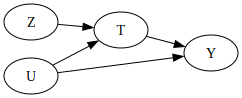

In [4]:
from graphviz import Digraph

gr = Digraph(format="png", graph_attr={"rankdir":"LR"})

gr.edge("U", "T")
gr.edge("U", "Y")
gr.edge("Z", "T")
gr.edge("T", "Y")

gr

* 은행이 프라임 신용카드를 제공했을 때 어떤 영향이 있는가?
    * 프라임 서비스를 제공할 때 고객에게 소액의 수수료를 부과한다.
    * 프라임 고객의 구매 고객이 최소 500달러 이상 증가하면 서비스는 가치가 있다.
    * 따라서 은행 프라임 카드가 고객의 구매 금액을 얼마나 늘리는지를 알고 싶어한다.
    * 무작위로 프라임 신용카드 이용 가능 여부를 배정하는 실험을 진행
        * 하지만 은행이 고객에게 카드를 선택하도록 강요할 수 없어 불응이 존재한다.
    * 변수 정리
        * 구매 금액 : Y
        * 프라인 신용카드의 사용 가능 여부 : Z
        * 프라임 카드 보유 여부 : T
        * 그 외 공변량 : X
        * 프라임 카드가 구매 금액에 미치는 실제 효과인 $\tau$ 와 고객이 속한 그룹 정보도 포함됨


In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv("./data/prime_card.csv")

df.head()

,age,income,credit_score,prime_elegible,prime_card,pv,tau,categ
0,37.7,9687.0,822.0,0,0,4913.79,700.0,complier
1,46.0,13731.0,190.0,0,0,5637.66,200.0,never-taker
2,43.1,2839.0,214.0,1,1,2410.45,700.0,complier
3,36.0,1206.0,318.0,1,1,1363.06,700.0,complier
4,39.7,4095.0,430.0,0,0,2189.80,700.0,complier


In [6]:
df.groupby(['prime_elegible'])['prime_card'].value_counts()

prime_elegible  prime_card
0               0             4976
1               0             2893
                1             2131
Name: count, dtype: int64

## 11.2 잠재적 결과 확장
* Z 가 T의 원인이므로 이제 잠재적 처치 $T_z$를 정의할 수 있다. 잠재적 결과는 도구변수 Z에 대한 새로운 반사실 $Y_{z,t}$를 가진다.
* 예시에서 Z는 무작위로 배정되었으므로, Z가 Y에 미치는 영향인 처치 의도 효과 (ITTE) 는 쉽게 식별할 수 있다.
    * $ITTE = E[Y|Z=1] - E[Y|Z=0] = E[Y_{1,t} - Y_{0,t}]$
* 처치 의도 효과는 단순선형회귀로 아래와 같이 추정한다.

In [7]:
m = smf.ols("pv~prime_elegible", data=df).fit()
m.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2498.3618,24.327,102.701,0.000,2450.677,2546.047
prime_elegible,321.3880,34.321,9.364,0.000,254.113,388.663


* 321.3880 은 프라임 신용카드를 사용함으로써 기대할 수 있는 고객당 추가 구매금액을 나타낸다. 하지만 ITTE 가 처치효과와 같지 않다는 점이 중요하다.
* 은행의 주요 목표는 프라임 카드의 혜택이 그 비용을 상회하는지를 결정하는 것이기 때문에 카드 선택에 따른 처치효과를 파악해야 한다.
* 이 사례는 단방향 불응 이 발생한다. (은행이 조건에 부합하는 고객들에게만 카드를 얻게 할 수 있도록 함)

* 프라임카드에 대한 효과를 식별하기 위해 가장 명확한 방법은 ITTE를 프라임 카드 효과의 대리변수로 사용하는 것이다.
    * 실험군과 대조군을 비교해 ITTE를 얻을 수 있지만 이 추정값은 ATE 추정값보다 0에 가깝게 편향될 수 있다.
    * -> 실험군의 일부 대상이 실제로 처치 받지 않으므로 두 그룹 간의 차이가 실제보다 줄어들기 때문이다.
    * 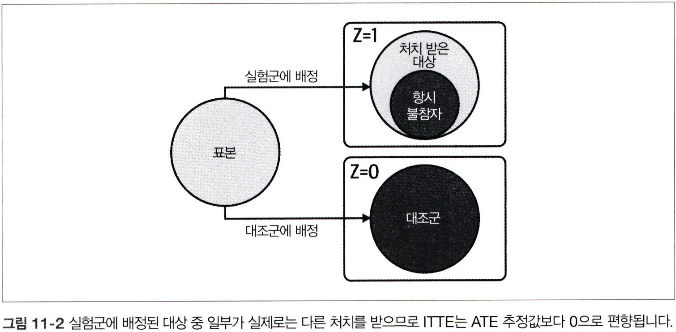
    * $\tau$ 의 평균값이 413 이므로 ITTE보다 훨씬 크다.

In [8]:
df["tau"].mean()

413.45

* 단순히 실험군과 대조군간 평균 비교 $E[Y|T=1] - E[Y|T=0]$ 으로 추정된 효과는 실제보다 더 크게 도출된다.
    * 이 예시에서는 상향편향이 존재하므로 프라임 카드를 선택한 고객은 프라임 카드에 관계없이 더 많이 지출하기 때문이다.
    * 아래 그림에서 항시 불참자는 순응자보다 $Y_0$ 이 낮으므로 처치 받지 않은 그룹의 평균 결과가 낮아지게 된다.
    * 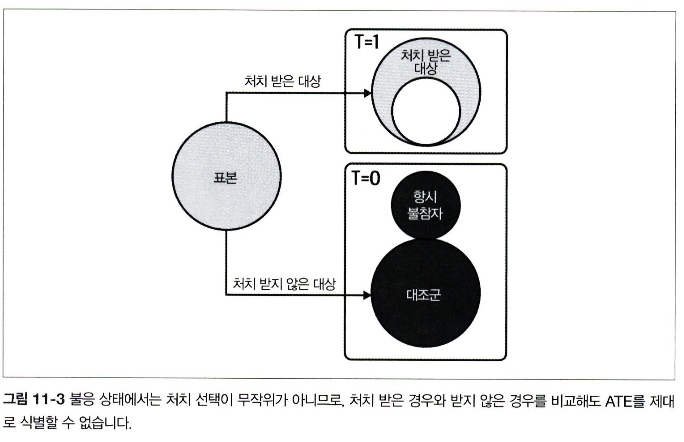

In [9]:
m = smf.ols("pv~prime_card", data=df).fit()
m.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2534.4947,19.239,131.740,0.000,2496.783,2572.206
prime_card,588.1388,41.676,14.112,0.000,506.446,669.831


## 11.3 도구변수 식별 가정
* 문제 해결을 위해 추가적인 가정이 필요하다.
1. 독립성
    * $Z$ 와 $T(T_z \perp Z|X)$ 그리고 $Z$ 와 $Y(Y(Z,T_z) \perp Z|X)$ 사이에 측정되지 않은 교란 요인이 없다고 가정하며, 도구변수가 마치 무작위로 배정된 것처럼 작용한다고 볼 수 있다. 이 가정은 직접 검증하기 어렵지만 실험 설계를 통해 설득력을 높일 수 있다. (예시에서는 프라임 카드의 사용을 무작위로 배정함)
2. 배제 제약 (exclusion restriction)
    * $Y_{z,t} = Y_t$ 로 표현하며, 처치 T를 거치지 않고 Z에서 Y로 가는 경로는 없다는 가정이다.
    * 도구변수는 처치를 통해서만 결과에 영향을 미쳐야한다. $Z$ 가 무작위로 배정되더라도 다른 경로로 결과에 영향을 미칠 수 있기 때문에 매우 까다롭다. 
    * 예시에서는 고객들이 자신이 배정된 그룹을 알냈고 대조군에 속한 고객이 은행에 항의해 계좌를 해지한다면, 무작위 배정은 처치와는 별개의 경로를 통해 결과에 영향을 줄 수 있다. 
3. 연관성 (relevance)
    * $E[T_1 - T_0] \ne 0$ 로 표현한다. Z에서 T로 향하는 관계가 존재하고, 도구변수가 처치변수에 유의미한 영향을 미쳐야한다. 이는 통계적으로 검증이 가능하다.
4. 단조성 (monotonicity)
    * $T_{i1} > T_{i0}$ 로 표현한다. 단순히 도구변수가 처치변수를 한 방향으로만 영향을 주는 것을 의미힌다. 도구변수의 영향을 받는 모든 대상의 처치 받을 확률이 단순히 증가하거나 감소하는 것을 의미한다.
    * 처치 받을 확률이 증가하는 경우 반항자가 없다고 가정하는 것이며, 반대로 감소하는 경우 순응자가 없다고 가정하는 것이다. 
    * 예시에서는 대조군의 고객이 프라임 신용카드를 억지로 발급받을 수 없으므로 이 가정도 만족한다고 볼 수 있다. (반항자는 불참자로 분류됨)

* 도구변수의 식별 과정
$$E[Y|Z=1] - E[Y|Z=0] = E[Y_1-Y_0 | T_1 > T_0]P(T_1 > T_0)$$
* $T_1 > T_0$ 은 순응자이고, 도구변수가 처치변수를 0에서 1로 전환하는 모집단이다. 위 식에서 도구변수가 결과변수에 미치는 영향은 순응자의 처치효과에 순응률을 곱한 값이다.
* 만약 순응률compliance rate 를 추정할 수 있으면 이전의 추정량을 보정할 수 있다.

* 종합하면, **도구변수가 결과에 미치는 영향을 도구변수가 처치에 미치는 영향인 순응률로 조정함으로써 순응자들에 대한 평균 처치효과를 식별** 할 수 있다.
* 도구변수를 사용해 불응에서의 효과를 식별할 수 있고 이는 ATE 가 아닌 순응자에 대한 효과인 국지적 평균처치 효과(local average treatment effect; LATE) 만 확인이 가능하다.
* 예시에서 LATE 는 프라임카드를 사용할 수 있을 때, 선택한 사람들에 대한 효과이다. 은행은 고객당 추가 구매금액의 효과가 프라임 카드의 비용을 상회하는지를 알고 싶은 것이었기에 LATE 를 아는 것만으로도 충분하다.

## 11.4 1단계
* 도구변수 분석의 첫 번쨰 단계를 1st stage regression 이라 하는데, 이는 처치변수를 도구변수에 대해 회귀하는 단계이다.
* 이 단계로 연관성 가정을 확인할 수 있다. 만약 회귀 계수 추정값이 충분히 크고 통계적으로 유의하다면 해당 가정이 유효하다 할 수 있다.

In [10]:
first_stage = smf.ols("prime_card ~ prime_elegible", data=df).fit()
first_stage.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4.252e-15,0.005,8.56e-13,1.000,-0.010,0.010
prime_elegible,0.4242,0.007,60.536,0.000,0.410,0.438


* 위 예시에서 순응률은 약 42% 라 할 수 있고 통계적으로 유의하다. 아래는 집계 결과는 각 고객이 속한 실제 그룹을 포함하므로 실제 순응률과 얼마나 일치하는지를 알 수 있다.

In [11]:
df.groupby("categ").size()/len(df)

categ
complier       0.4269
never-taker    0.5731
dtype: float64

## 11.5 2단계
* 도구변수 분석의 두 번째 단계는 2nd stage regression 혹은 reduced form 이라 한다. 이 단계에서는 결과를 도구 변수에 회귀해 처치 의도 효과를 추정한다.
* 1단계 와 2단계인 축약형 단계를 진행한 후 전자의 매개변수 추정값(순응률)을 2단계의 매개변수 추정값으로 나누어 LATE를 구한다.

In [12]:
red_form = smf.ols("pv ~ prime_elegible", data=df).fit()
red_form.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2498.3618,24.327,102.701,0.000,2450.677,2546.047
prime_elegible,321.3880,34.321,9.364,0.000,254.113,388.663


In [13]:
late = (red_form.params["prime_elegible"] /
        first_stage.params["prime_elegible"])
late

757.6973795343963

* 이 효과는 ITTE 의 두배 이상이다. 이는 순응률이 50%보다 낮기 때문에 예상할 수 있는 결과이다. 또한 순응자들을 통해 구해진 LATE 는 ATE 보다 크다
* 그럼에도 여전히 차이가 있는데 신뢰구간을 활용하지 않으면 부트스트랩을 활용할 수 있지만 도구변수 추정값의 표준오차를 계산하는 실제 공식을 살펴보는게 좋다.

In [14]:
df.groupby("categ")["tau"].mean()

categ
complier       700.0
never-taker    200.0
Name: tau, dtype: float64

## 11.6 2단계 최소제곱법
* LATE 를 추정하는 또다른 방법으로 2단계 최소제곱법 (2-stage least squares) 이 있다.
* 1단계는 처치변수를 도귀변수에 회귀하는 ㄷ나계이며 이는 본질적으로 Z -> T 의 경로를 추정하는 것을 의미한다. 여기서 구할 수 있는 추정된 $\hat{T}$ 는 편향되지 않은 처치변수라 할 수 있다.
* 그 다음 2단계 축약형에서 결과 변수를 앞에서 구한 예측값에 대해 회귀하면 도구변수의 추정값을 구할 수 있게 된다.

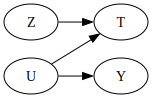

In [15]:
gr = Digraph(format="png", graph_attr={"rankdir":"LR"})

gr.edge("U", "T")
gr.edge("U", "Y")
gr.edge("Z", "T")
gr

In [16]:
iv_regr = smf.ols(
    "pv ~ prime_card",
    data=df.assign(prime_card=first_stage.fittedvalues)).fit()

iv_regr.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2498.3618,24.327,102.701,0.000,2450.677,2546.047
prime_card,757.6974,80.914,9.364,0.000,599.091,916.304


* two-stage least square 가 유용한 이유는
    * 표준오차를 적절하게 계산할 수 있고
    * 회귀 모델에서 변수를 추가할 때만큼이나 쉽게 더 많은 도구변수와 공변량을 추가할 수 있기 때문이다.

## 11.7 표준오차
* 축약형 단계 예측의 잔차는 $\hat{e}_{IV} = Y - \hat{\beta}_{IV}T$ 이다.
* 이 잔차를 이용해 도구변수 추정값에 대한 표준 오차를 아래와 같이 계산할 수 있다.
    * $SE = \frac{\sigma(\hat{\epsilon}_{IV})}{\hat{\beta}_{z,1st}}\sigma(Z)\sqrt{n}$


In [17]:
Z = df["prime_elegible"]
T = df["prime_card"]
n = len(df)

# not the same as iv_regr.resid!
e_iv = df["pv"] - iv_regr.predict(df)
compliance = np.cov(T, Z)[0, 1]/Z.var()

se = np.std(e_iv)/(compliance*np.std(Z)*np.sqrt(n))

print("SE IV:", se)
print("95% CI:", [late - 2*se, late + 2*se])

SE IV: 80.5286102614194
95% CI: [596.6401590115574, 918.7546000572352]


In [18]:
from linearmodels import IV2SLS

formula = 'pv ~ 1 + [prime_card ~ prime_elegible]'
iv_model = IV2SLS.from_formula(formula, df).fit(cov_type="unadjusted")

iv_model.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,2498.4,24.211,103.19,0.0000,2450.9,2545.8
prime_card,757.70,80.529,9.4090,0.0000,599.86,915.53


In [19]:
print(iv_model.params)
print(iv_model.conf_int(level=0.95))


Intercept     2498.361754
prime_card     757.697380
Name: parameter, dtype: float64
                  lower        upper
Intercept   2450.909491  2545.814018
prime_card   599.864204   915.530555


* 수식 상에서 분모에 순응률을 추가하는게 OLS 표준 오차 공식과 다른 점이라 할 수 있다. 이 순응률이 100% 보다 낮은 값이기 때문에 표준오차가 불응인 경우에 증가하게 된다. 
* 순응률이 50%라면 도구변수 표준오차는 OLS 때보다 2배 커지게 된다. 따라서 순응률이 50% 인 실험에 필요한 표본 크기는 순응률이 100%인 경우에 필요한 표본의 4배가 된다. ($\sqrt(n)$ 에 반비례하기 때문이다.)

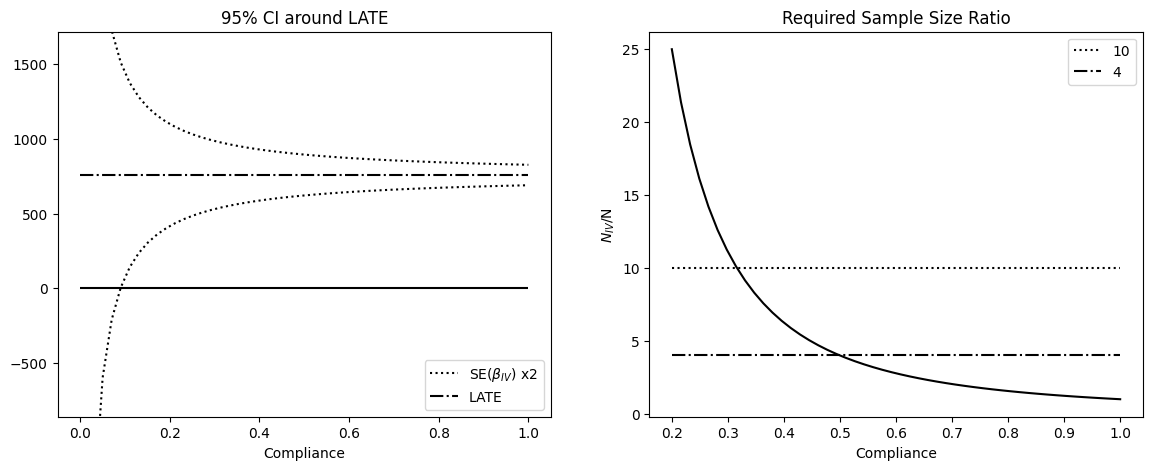

In [20]:
se_formula_iv = lambda compliance: np.std(e_iv)/(compliance*np.std(Z)*np.sqrt(n))
x = np.linspace(0.01, 1, 50)

effect = iv_regr.params["prime_card"]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(x, effect-se_formula_iv(x)*2, label="SE($\\beta_{IV}$) x2", ls=":", color="0")
ax1.plot(x, effect+se_formula_iv(x)*2, ls=":", color="0")
ax1.hlines(effect, 0, 1, ls="-.", label="LATE")
ax1.hlines(0, 0, 1)
ax1.set_xlabel("Compliance")
ax1.set_ylim(-(effect+100), (effect+100)*2)
ax1.legend(loc="lower right")
ax1.set_title("95% CI around LATE");


x = np.linspace(0.2, 1, 50)
ax2.plot(x, 1/(x**2))
ax2.hlines(10, 0.2, 1, ls=":", label="10")
ax2.hlines(4, 0.2, 1, ls="-.", label="4")
ax2.set_xlabel("Compliance")
ax2.set_ylabel("$N_{IV}$/N")
ax2.set_title("Required Sample Size Ratio")
ax2.legend()


* 결국 순응률이 낮을수록 많은 수의 표본을 확보하는게 필요한데 이는 예시와 같은 상황에서 어려운 경우가 많다. 이러한 문제가 발생한 상황에서 도구변수 표준오차를 낮출 수 있는 방법 중 하나는 추가 공변량을 포함하는 것이다.

## 11.8 통제변수와 도구변수 추가


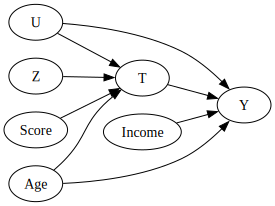

In [21]:
gr = Digraph(format="png", graph_attr={"rankdir":"LR"})

gr.edge("U", "T")
gr.edge("U", "Y")
gr.edge("Z", "T")
gr.edge("T", "Y")
gr.edge("Income", "Y")
gr.edge("Age", "T")
gr.edge("Age", "Y")
gr.edge("Score", "T")

gr

* 위와 같이 여러 공변량이 Z, T, Y 와 연결되는 관계를 확인해 이를 회귀에 반영하면 표준오차를 줄일 수 있다.
* 예시에서 신용점수는 프라임 카드 선택 순응의 원인이지만 결과 변수의 원인은 아니다. 이 또한 추가 도구변수로 취급할 수 있다. 
* 여기서 주의할 점은 신용점수를 도구변수로 취급하는 대신 두 번째 단계에서도 추가하면 오차가 증가하게 된다는 점이다.
    * 또한, 결과가 아닌 처치의 원인을 조건화하면 추정값의 분산이 증가하는 문제가 있고
    * 만약 신용점수와 같이 데이터 생성 과정을 알고 신뢰할 수 있는 변수가 아닌 다른 변수를 도구변수로 활용하면 가정을 위배할 수 있다.
* 대부분의 공변량들은 처치 순응과 결과에 모두 영향을 준다. (에시에서는 Age 가 이에 해당한다.) 이와 같은 결과를 잘 예측하는 통제변수를 포함해서 도구변수 추정값의 분산을 줄이는 것도 중요하다. 

In [22]:
formula = 'pv ~ 1 + [prime_card ~ prime_elegible + credit_score]'
iv_model = IV2SLS.from_formula(formula, df).fit()

iv_model.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,2519.4,21.168,119.02,0.0000,2477.9,2560.9
prime_card,659.04,58.089,11.345,0.0000,545.19,772.90


In [23]:
formula = '''pv ~ 1 
+ [prime_card ~ prime_elegible + credit_score]
+ income + age'''

iv_model = IV2SLS.from_formula(formula, df).fit(cov_type="unadjusted")

iv_model.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,210.62,37.605,5.6008,0.0000,136.91,284.32
income,0.3998,0.0008,471.04,0.0000,0.3981,0.4014
age,9.7444,0.8873,10.982,0.0000,8.0053,11.483
prime_card,693.12,12.165,56.978,0.0000,669.28,716.96


### 11.8.1 2SLS 직접 구현
* 공변량을 포함한 2SLS 를 직접 구현하면 아래와 같다.

In [24]:
formula_1st = "prime_card ~ prime_elegible + credit_score + income+age"
first_stage = smf.ols(formula_1st, data=df).fit()

iv_model = smf.ols(
    "pv ~ prime_card + income + age",
    data=df.assign(prime_card=first_stage.fittedvalues)).fit()

iv_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,210.6177,40.832,5.158,0.000,130.578,290.657
prime_card,693.1207,13.209,52.474,0.000,667.229,719.013
income,0.3998,0.001,433.806,0.000,0.398,0.402
age,9.7444,0.963,10.114,0.000,7.856,11.633


### 11.8.2 행렬 구현
* 표준오차를 구하고 싶다면 2SLS를 행렬로 표현해 구현할 수 있다.
* 2SLS 의 표준오차 공식은 아래와 같다.
    * $SE(\hat{\beta{IV}}) \approx \frac{\sigma(\hat{e}_{IV})}{\sigma(\tilde{T})\sqrt{nR_{1st}^{2}}}$
* 위 식을 통해 도구 변수 추정값의 표준오차를 줄이는 방법은 3가지로 정리할 수 있다.
    * 1. 1단계의 $R^2$ 를 증가시킨다. 순응을 잘 예측하는 강력한 도구변수를 찾아야 한다. 해당 변수들은 결과에 영향을 미치지 않으면서 배제 제약을 만족해야 한다.
    * 2. T에 대한 예측력이 높은 변수를 제거하여 $\sigma(\tilde{T})$ 를 증가시킨다. 
    * 3. 결과의 예측력이 높은 변수를 찾아서 2단계의 잔차를 줄인다. -> 현실적으로 가장 적합한 방법

In [25]:
Z = df[["prime_elegible", "credit_score", "income", "age"]].values
X = df[["prime_card", "income", "age"]].values
Y = df[["pv"]].values

def add_intercept(x):
    return np.concatenate([np.ones((x.shape[0], 1)), x], axis=1)

Z_ = add_intercept(Z)
X_ = add_intercept(X)

# pre-multiplying Z_.dot(...) last is important to avoid
# creating a huge NxN matrix
X_hat = Z_.dot(np.linalg.inv(Z_.T.dot(Z_)).dot(Z_.T).dot(X_))

b_iv = np.linalg.inv(X_hat.T.dot(X_hat)).dot(X_hat.T).dot(Y)
b_iv[1]

array([693.12072518])

In [26]:
e_hat_iv = (Y - X_.dot(b_iv))

var = e_hat_iv.var()*np.diag(np.linalg.inv(X_hat.T.dot(X_hat)))

np.sqrt(var[1])

12.16469439503309

In [27]:
t_tilde = smf.ols("prime_card ~ income + age", data=df).fit().resid

e_hat_iv.std()/(t_tilde.std()*np.sqrt(n*first_stage.rsquared))

12.156252763192311

## 11.9 불연속 설계
* 회귀 불연속 설계(Regression Discountinuity design ; RDD) 는 기존의 도구변수 및 불응 설계와 더불어 중요한 방법 중 하나이다. 이는 처치 배정에 인위적인 불연속성을 활용해 처치 효과를 식별하는 방법이다.
* 회귀 불연속 설계는 현업에서 유용할 수 있지만, 그 활용도는 상대적으로 제한적이다.
    * 예를 들어, 은행이 모든 고객에게 신규 신용카드를 제공하지만 계좌 잔고가 5k$ 이하인 고객에게는 수수료를 부과한다고 가정해보자. 이는 카드 제공 방식에 불연속성을 만들어 카드 선택의 가능성이 임계값에서 달라지게 된다. 이런 경우에 회귀 불연속 설계를 활용해 신규 카드 제공의 효과를 추정할 수 있다.
* 프라임 카드 예시에 적용할 때 기본 아이디어는 임계값을 넘으면 처치 받을 가능성이 달라진다는 점을 인식해 임계값을 하나의 도구변수로 이해하는 것이다.
* 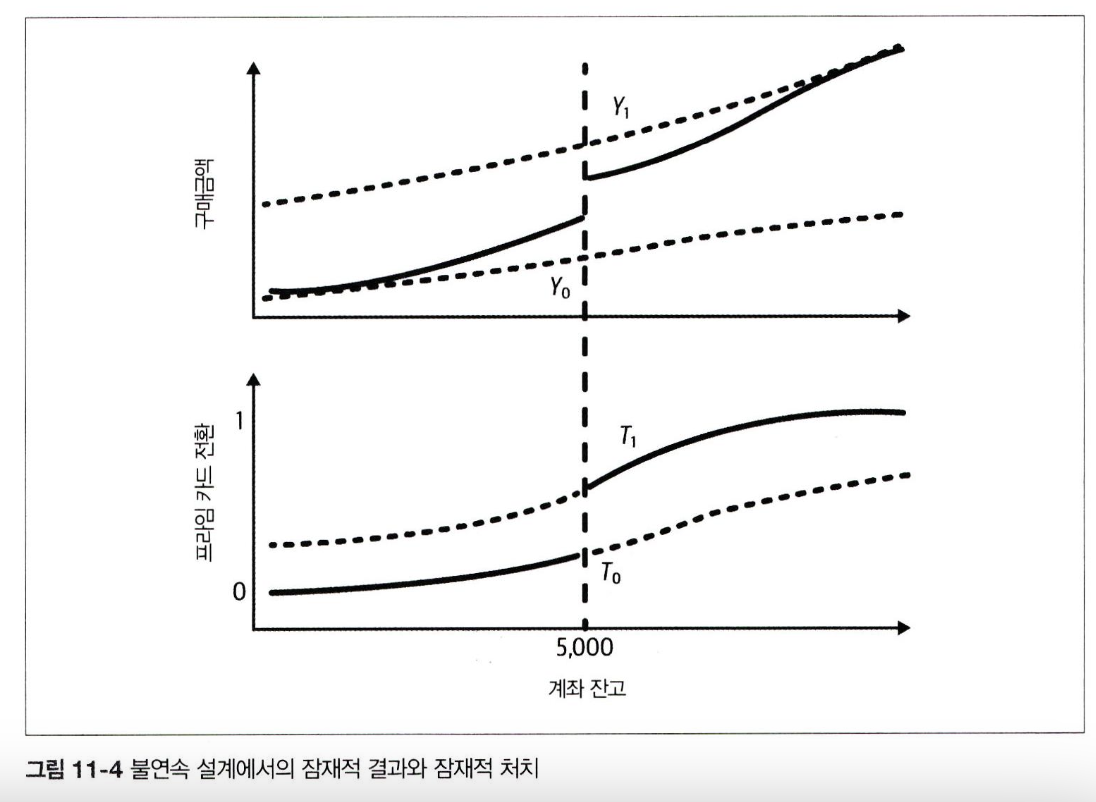
* 만약 예시에서 위의 그림과 같이 계좌 잔고에 따라 카드 전환율이 달라지고 이에 따라 처치 확률의 변화가 결과에 미치는 영향을 추정하고자 한다면, 임계값에서의 처치 효과가 실제보다 작게 보이게 하기 때문에 도구변수를 사용해 이를 보정해야 한다.

### 11.9.1 불연속 설계 가정
* 회귀 불연속 설계에는 도구변수 가정외에도 잠재적 결과 및 잠재적 처치 함수의 평활도에 대한 추가 가정이 필요하다.
* 처치 확률이 임계값 $R=c$ 에서, 해당 변수의 불연속 함수가 되도록 배정 변수 R 을 정의해보면 (예제에서 R은 은행 잔고, c 는 5000$) 아래와 같은 가정이 필요하다.
    * $\lim_{r \to c^{-}}E[Y_t|R=r] = \lim_{r \to c^{+}}E[Y_t|R=r]$
    * $\lim_{r \to c^{-}}E[T_z|R=r] = \lim_{r \to c^{+}}E[T_z|R=r]$
*  LATE 추정량
    * $LATE = E[Y_1-Y_0|T_1 > T_0, R= c]$
* 중요한 점은 이 추정량이 두 가지 의미에서 국소적이라는 점이다.
    * 임계값 R=c 에서만 처치효과를 주는 것 (불연속 설계의 국소성)
    * 순응자의 처치효과만 추정

### 11.9.2 처치 의도 효과
* 아래 데이터는 계좌잔고, 프라임카드 선택 여부, 구매 금액 정보가 포함된 데이터이다.

In [28]:
df_dd = pd.read_csv("./data/prime_card_discontinuity.csv")
df_dd.head()

,balance,prime_card,pv,tau,categ
0,12100.0,1,356.472,300.0,always-takers
1,4400.0,1,268.172,300.0,always-takers
2,4600.0,1,668.896,300.0,always-takers
3,3500.0,1,428.094,300.0,always-takers
4,12700.0,1,1619.793,700.0,complier


* 배정변수인 잔고를 5000$을 중심으로 임계값을 0으로 조정해 매개변수 해석을 용이하게 할 수 있다.
* 아래의 결과는 임계값 위 아래에 해당하는 두 개의 회귀선을 추정한 결과라 할 수 있다. 순응문제가 없다면, 즉 임계값을 초과하는 모든 대상이 처치를 받고 임계값 미만에 해당하는 사람들이 모두 처치 받지 않는다면 이 접근 방식을 활용할 수 있다. 여기서 순응률이 100%라면 ITTE 는 ATE 와 같다.

In [29]:
m = smf.ols(f"pv~balance*I(balance>0)",
            df_dd.assign(balance = lambda d: d["balance"] - 5000)).fit()
m.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,559.2980,8.395,66.621,0.000,542.843,575.753
I(balance > 0)[T.True],261.0699,10.128,25.777,0.000,241.218,280.922
balance,0.0616,0.005,11.892,0.000,0.051,0.072
balance:I(balance > 0)[T.True],-0.0187,0.005,-3.488,0.000,-0.029,-0.008


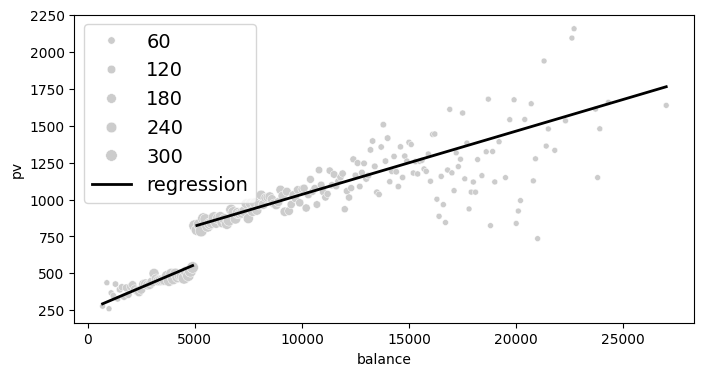

In [30]:
plt_df = df_dd.round({"balance": -2}).assign(size=1).groupby("balance").agg({"pv":"mean", "size": "sum"}).reset_index()

plt.figure(figsize=(8,4))
sns.scatterplot(data=plt_df, y="pv", x="balance", size="size", color="C5")
plt.plot(plt_df.query("balance<5000")["balance"], m.predict(plt_df.query("balance<5000").assign(balance = lambda d: d["balance"] - 5000)), color="C0", lw=2, label="regression")
plt.plot(plt_df.query("balance>5000")["balance"], m.predict(plt_df.query("balance>5000").assign(balance = lambda d: d["balance"] - 5000)), color="C0", lw=2)
plt.legend(fontsize=14)


### 11.9.3 도구변수 추정값
* 문제는 순응률이 100%가 아니기 때문에 ITTE 를 순응률로 나누어야 한다. 이는 불연속 설계 상에서 임계값이 넘은 경우에 처치 확률이 얼마나 변하는지를 의미한다.
* 아래의 함수는 ITTE 를 구하고 순응률을 추정해 ITTE / 순응률 로 LATE 를 추정하는 과정을 포함하고 있다.

In [36]:
def rdd_iv(data, y, t, r, cutoff):
    
    centered_df = data.assign(**{r: data[r]-cutoff})
    
    compliance = smf.ols(f"{t}~{r}*I({r}>0)", centered_df).fit()
    itte = smf.ols(f"{y}~{r}*I({r}>0)", centered_df).fit()
    
    param = f"I({r} > 0)[T.True]"
    return itte.params[param]/compliance.params[param]


rdd_iv(df_dd, y="pv", t="prime_card", r="balance", cutoff=5000)

732.8534752298928

In [32]:
(df_dd
 .round({"balance":-2}) # round to nearest hundred
 .query("balance==5000 & categ=='complier'")["tau"].mean())

700.0

* 신뢰구간을 구하기 위한 공식을 유도할 수 있지만 전체 함수를 부트스트랩 과정으로 간단히 묶는 방법이 가장 쉽다.

In [33]:
from joblib import Parallel, delayed
from toolz import partial

def bootstrap(data, est_fn, rounds=200, seed=123, pcts=[2.5, 97.5]):
    np.random.seed(seed)
    
    stats = Parallel(n_jobs=4)(
        delayed(est_fn)(data.sample(frac=1, replace=True))
        for _ in range(rounds)
    )
    
    return np.percentile(stats, pcts)


bootstrap(df_dd,
          partial(rdd_iv, y="pv", t="prime_card", r="balance", cutoff=5000))

array([655.08214249, 807.83207567])

### 11.9.4 밀도 불연속 테스트
* 불연속 설계에 대한 식별의 잠재적 문제
    * 대상(고객들) 이 배정변수를 조작할 수 있다면 스스로를 실험군에 포함시킬 수도 있다. (예시에서 고객은 프라임카드를 받기 위해 계좌 잔고를 임계값에 달할 때까지 늘린다면 임계값 바로 위 아래를 비교할 수 없게 만들게 된다. )
    * 임계값 주변의 밀도를 그래프로 나타내 만약 임계값에서 밀도가 크게 증가하는 현상이 나타난다면 이를 의심할 수 있다.
* 또한 아래의 두 가지 사항을 고려해야 한다.
    * 대역폭 : 배정 변수 전후로 어느 정도의 구간을 실험에 사용할 것인지에 따라 결과가 달라진다.
    * 함수 형태 : 위 예시에서는 선형 회귀로 추정을 진행했지만 비선형적인 케이스가 존재할 수 있으며 같은 그래프여도 함수 형태 가정에 따라 해석이 달라진다.

Text(0.5, 0, 'Balance (rounded to nearest 1000)')

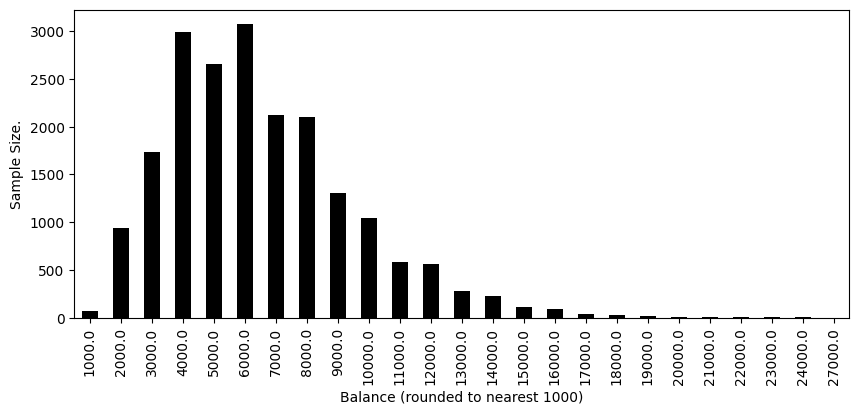

In [34]:
plt.figure(figsize=(10,4))
df_dd.round({"balance":-3}).groupby("balance").size().plot.bar()
plt.ylabel("Sample Size.")
plt.xlabel("Balance (rounded to nearest 1000)")

## 11.10 요약


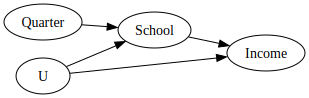

In [35]:
gr = Digraph(format="png", graph_attr={"rankdir":"LR"})

gr.edge("U", "School")
gr.edge("U", "Income")
gr.edge("Quarter", "School")
gr.edge("School", "Income")
gr

## 추가 자료

* 내생성 (Endogeneity)은 회귀분석 맥락에서 원인변수와 오차항 간의 상관관계가 존재하는 것을 의미하는 통계적인 개념이지만, 개념적으로는 인과추론을 방해하는 모든 요인들을 통칭한다고 이해해도 무방하다.
* omitted variable bias 나 selection bias 는 내생성을 야기하는 하나의 요인이다.
    * 핵심은 "Treatment 를 받는 과정을 어떻게 설명하느냐"
* 내생성을 극복하기 위한 방법들 
    * 도구변수가 selection process 의 역할을 하게 되면 LATE 방법을 활용하는 것
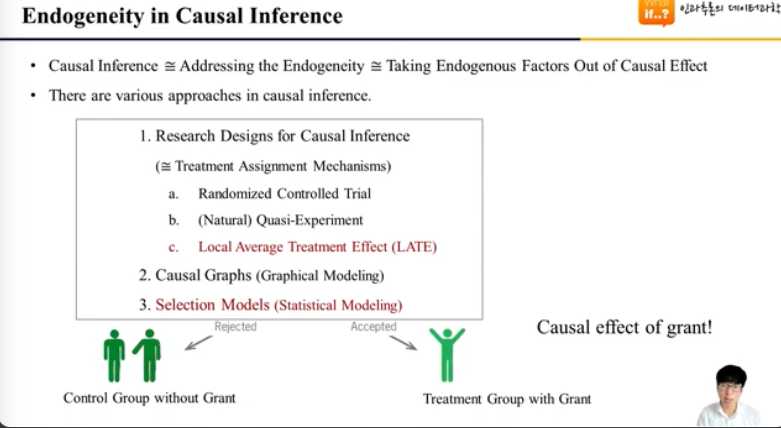

* 회귀분석 맥락에서 내생성 문제를 정의하는 방법
    * 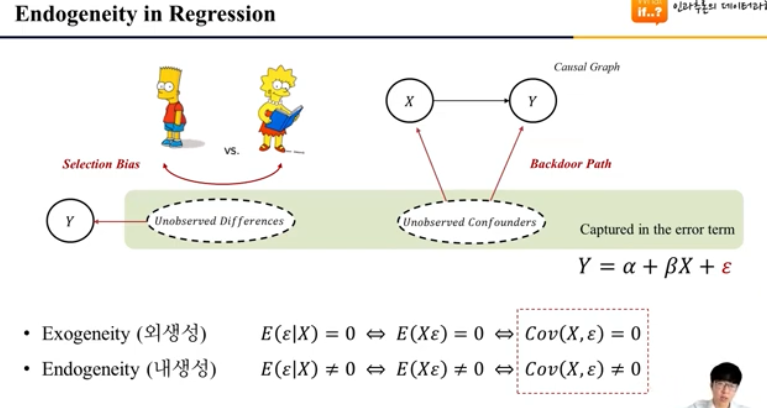

* 도구변수는 treatment variable 가지는 내생성, 외생성을 구분하는 도구로의 역할을 수행하는 것
    * 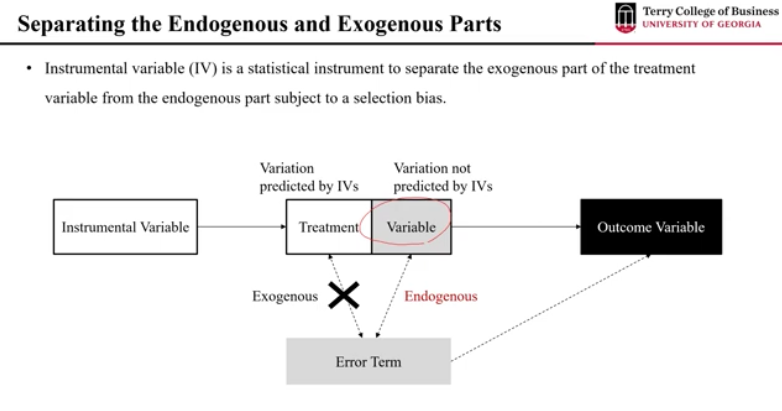

* discontinuous jump 를 발생하게 되는 구간을 포함하는 variable ~ Running variable
* Running variable 을 활용해 counterfactual 을 추정
* 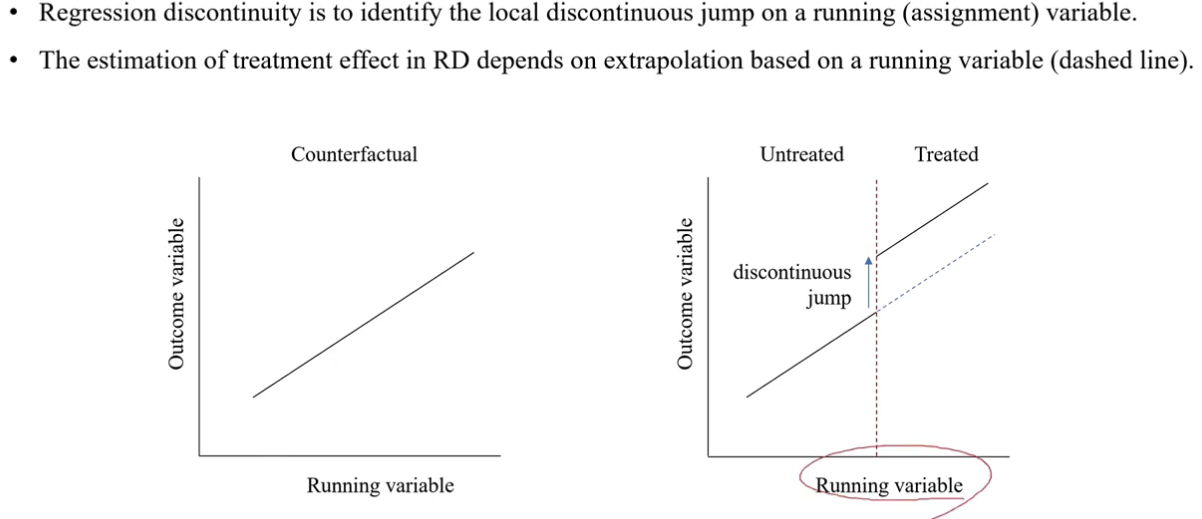

* RDD 에서 중요한 요인 2가지
    * 얼만큼의 범위로 분석 대상을 설정할 것인지 -> bandwidth (일반적으로 여러 bandwidth 를 test)
    * Running variable 을 어떻게 모델링할 것인지 -> Parametric / Non-parametric
* RDD 는 cut-off 를 기준으로 counterfactual 을 추정 (Treatment 전/후의 데이터가 관측이 어려운 경우)
* cut-off 는 Outcome 과 관계없이 정의되어야 함
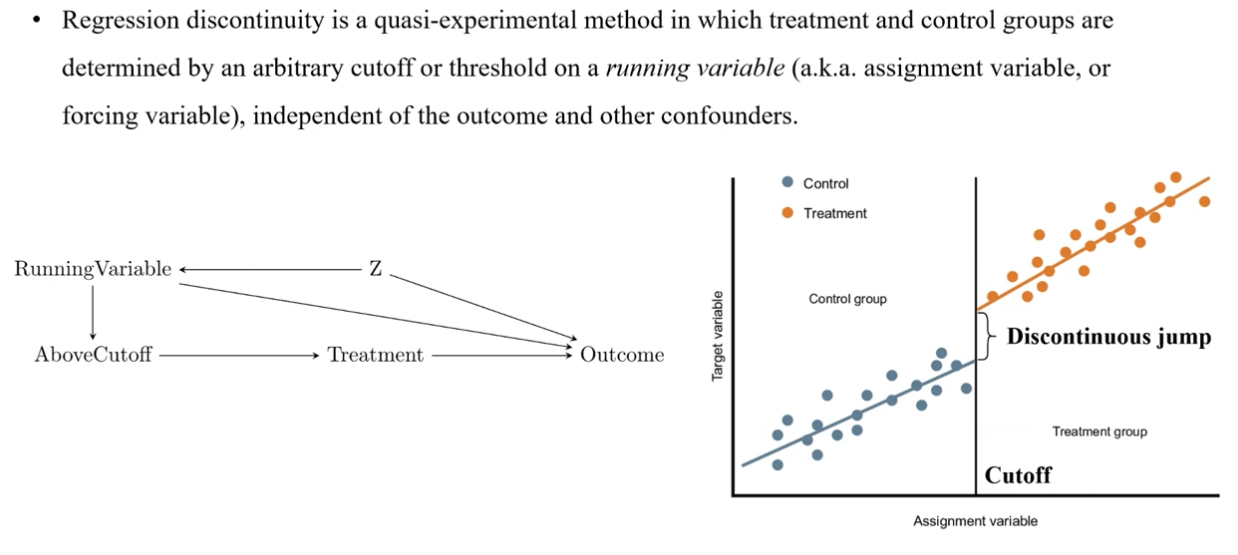
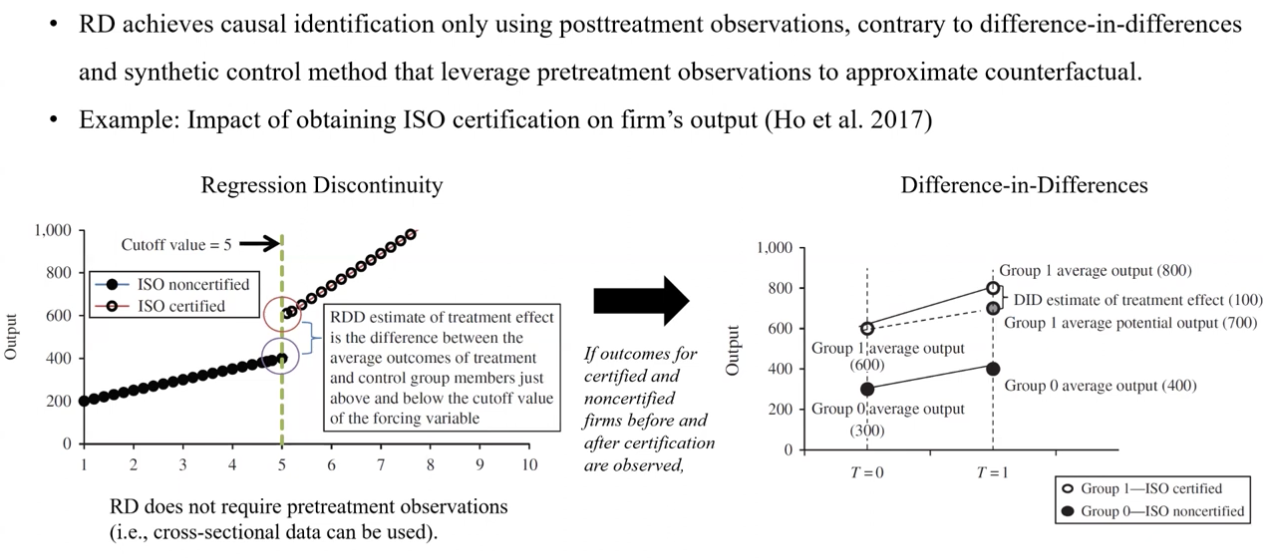

* RD 의 modeling 선택 기준 > 일반적으로 다양한 방법들을 같이 고려함 (단, Global Nonparametric 은 거의 활용x)
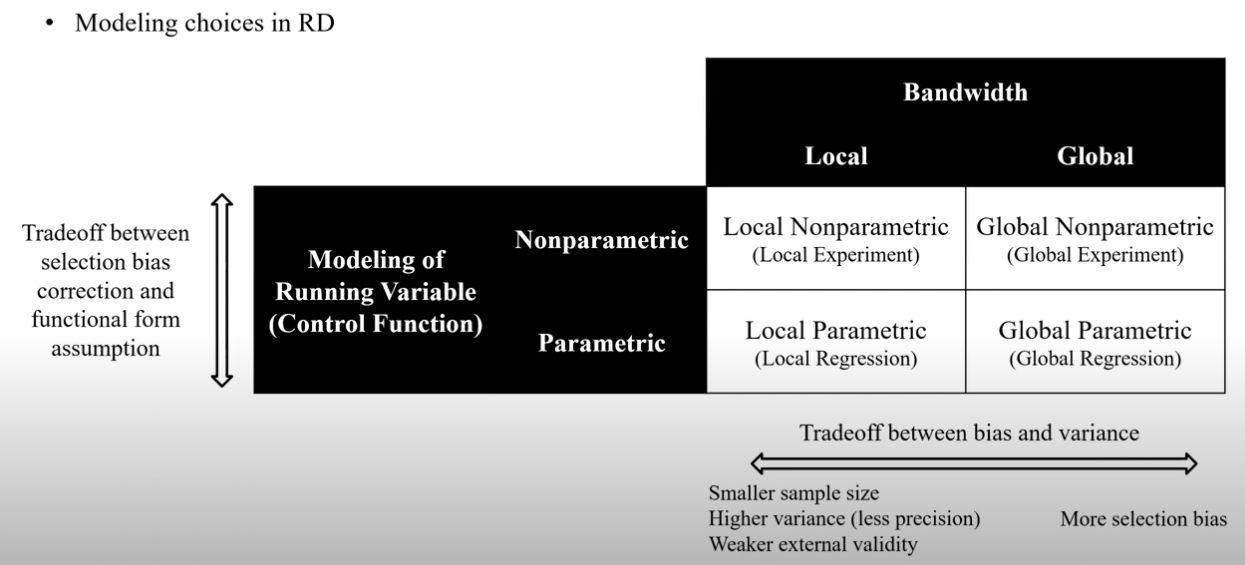

* non-parametric
    * indicator variable
    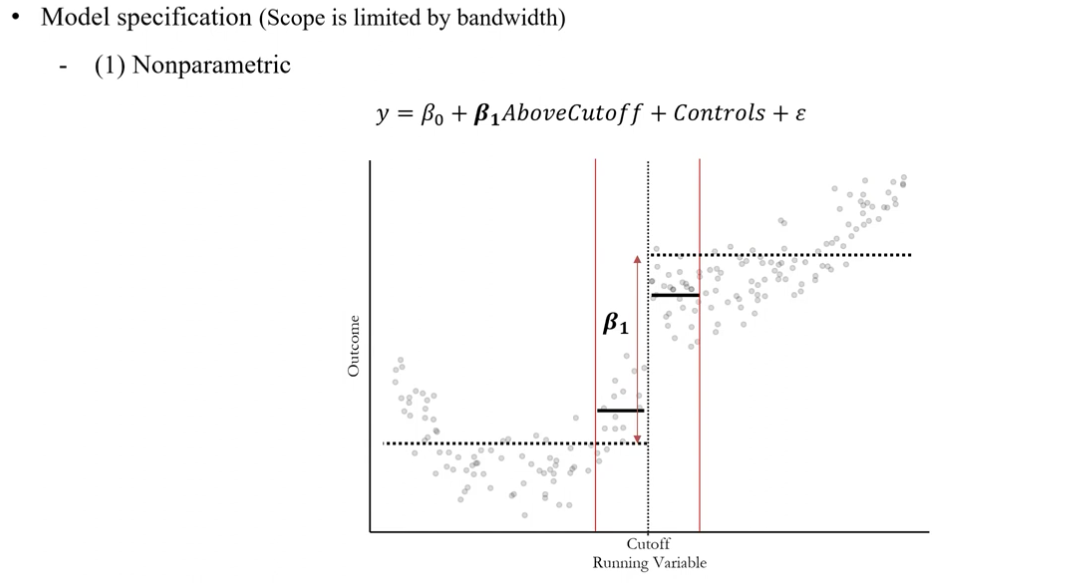

* Parametric
    * cut-off 를 기준으로 Running variable 에 대해서 서로 다른 fucntion 을 정의
    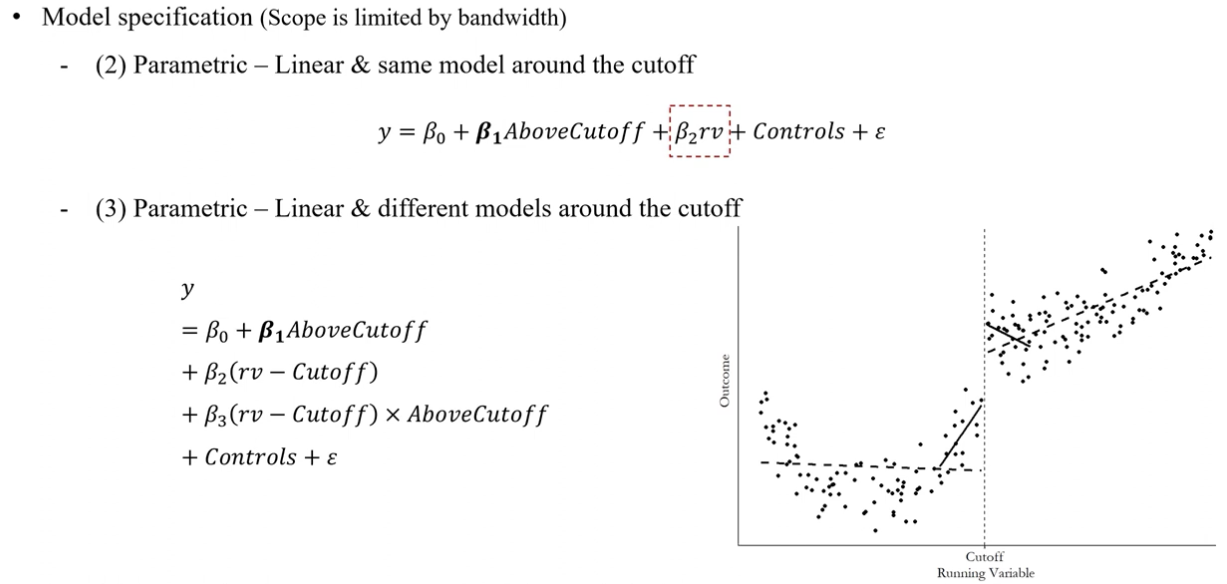
    * Quadratic-form
    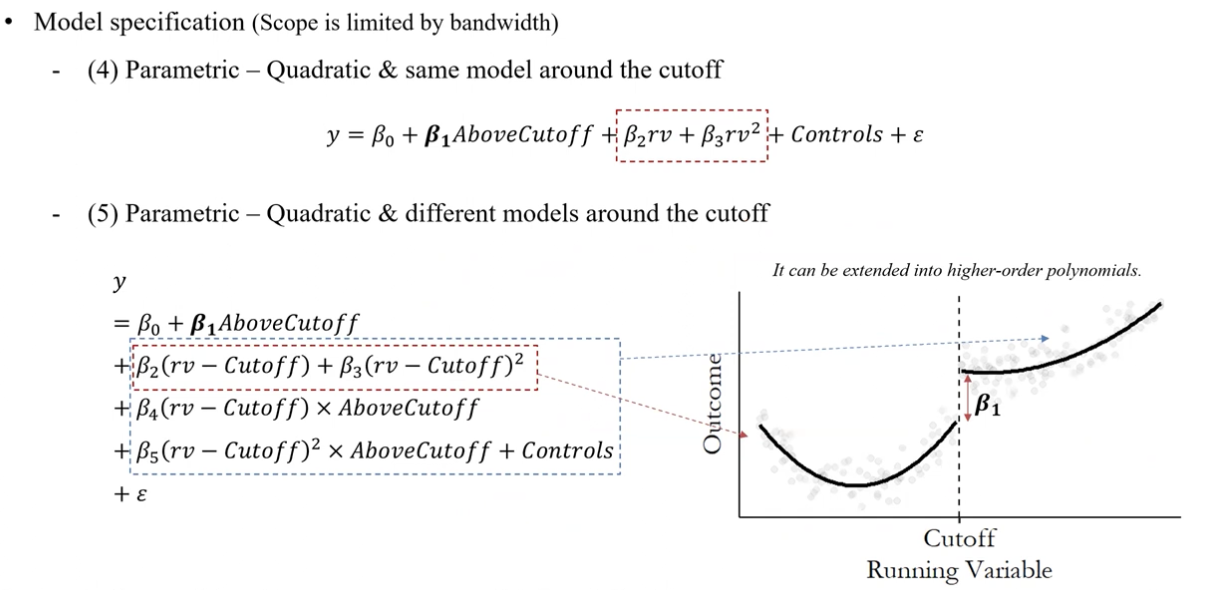